# Data

https://www.kaggle.com/moltean/fruits/version/2 

https://github.com/Horea94/Fruit-Images-Dataset

# Dependencies

In [3]:
import os
import random
from skimage import io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch, torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
import h5py
import cv2

gpu = torch.device('cuda:0')
cpu = torch.device('cpu')

# Load image dataset

Set working directory to parent directory containing fruit dataset

In [3]:
# Load in train images and labels

X_train, y_train = [], []

for dirs in os.listdir():
    if os.path.isdir(dirs):
        curr_label = dirs
        os.chdir(dirs)
        for i in os.listdir():
            X_train.append(io.imread(i))
            y_train.append(curr_label)
        os.chdir('..')

In [4]:
print(len(X_train), len(y_train))

60486 60486


**Check for class imbalance**

In [5]:
pd.Series(y_train).value_counts()

Grape Blue     984
Plum 3         900
Peach 2        738
Cherry 2       738
Tomato 1       738
              ... 
Mangostan      300
Pear Kaiser    300
Nut Forest     218
Nut Pecan      178
Ginger Root     99
Length: 120, dtype: int64

In [6]:
pd.Series(y_train).value_counts().describe()

count    120.000000
mean     504.050000
std      115.492359
min       99.000000
25%      470.250000
50%      490.000000
75%      492.000000
max      984.000000
dtype: float64

**Randomly oversample data to create even number of samples in each class: 1000 images per class, 120k train images total**

In [7]:
X_train_oversample = X_train.copy()
y_train_oversample = y_train.copy()

In [8]:
# Retrieve all unique image labels
y_unique = np.unique(y_train)

# For each unique label, determine range of index values (start, stop) and random sample from within that range.
# The number of samples (for n in range()) depends on the number of images needed to reach 1000 for that class.

for idx in range(len(y_unique)):
    start = y_train.index(y_unique[idx])
    stop = y_train.index(y_unique[idx+1]) if idx < len(y_unique)-1 else len(y_train)
    for n in range((1000 - (stop-start))):
        random_sample = random.randint(start, stop-1)
        X_train_oversample.append(X_train[random_sample])
        y_train_oversample.append(y_train[random_sample])

In [9]:
pd.Series(y_train_oversample).value_counts().describe()

count     120.0
mean     1000.0
std         0.0
min      1000.0
25%      1000.0
50%      1000.0
75%      1000.0
max      1000.0
dtype: float64

**Load in test data**

In [10]:
# Load in test images and labels
os.chdir("../Test")

X_test, y_test = [], []

for dirs in os.listdir():
    if os.path.isdir(dirs):
        curr_label = dirs
        os.chdir(dirs)
        for i in os.listdir():
            X_test.append(io.imread(i))
            y_test.append(curr_label)
        os.chdir('..')

**Confirm image and labels length:**

In [11]:
print('Train: ', len(X_train_oversample), len(y_train_oversample))
print('Test: ', len(X_test), len(y_test))

Train:  120000 120000
Test:  20618 20618


**Confirm image/label for first and last train sample**

Apple Braeburn


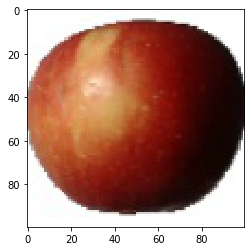

In [12]:
print(y_train_oversample[0]); plt.show(plt.imshow(X_train_oversample[0]))

Walnut


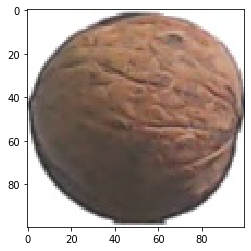

In [13]:
print(y_train_oversample[-1]); plt.show(plt.imshow(X_train_oversample[-1]))

In [14]:
X_train = X_train_oversample

**Factorize and one-hot encode labels, convert to Torch tensors**

In [15]:
y_train_factors = list(pd.factorize(y_train_oversample))
y_test_factors = list(pd.factorize(y_test))

In [16]:
y_train_factors[0] = F.one_hot(torch.tensor(y_train_factors[0])).float()
y_test_factors[0] = F.one_hot(torch.tensor(y_test_factors[0])).float()

y_train_onehot, y_test_onehot = y_train_factors[0], y_test_factors[0]

In [17]:
print(y_train_factors[1][0], '\n'); print(y_train_onehot[0])

Apple Braeburn 

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


**Normalize image data and convert to Torch tensors**

In [18]:
X_train = torch.tensor(np.array(X_train)).float()
X_train = torch.div(X_train, 255)

In [19]:
X_test = torch.tensor(np.array(X_test)).float()
X_test = torch.div(X_test, 255)

**Save dataset**

In [20]:
fruit_data = h5py.File('fruits-360/fruit_data.h5', 'w')

In [21]:
fruit_data.create_dataset('X_train', data=X_train)
fruit_data.create_dataset('X_test', data=X_test)
fruit_data.create_dataset('y_train', data=y_train_factors[0])
fruit_data.create_dataset('y_test', data=y_test_factors[0])

<HDF5 dataset "y_test": shape (20618, 120), type "<f4">

In [22]:
fruit_data.close()

***

# Build CNN

**Load fruit**

In [2]:
fruit_data = h5py.File('fruits-360/fruit_data.h5', 'r')
X_train = fruit_data['X_train']
X_test = fruit_data['X_test']
y_train = fruit_data['y_train']
y_test = fruit_data['y_test']

In [ ]:
X_train = torch.tensor(np.array(X_train))
X_test = torch.tensor(np.array(X_test))
y_train = torch.tensor(np.array(y_train))
y_test = torch.tensor(np.array(y_test))

In [ ]:
print(y_train[0])
plt.show(plt.imshow(X_train[0]))

In [ ]:
y_train_onehot = y_train
y_test_onehot = y_test

**Observe tensor axes, reshape for PyTorch format**

In [ ]:
X_train.shape

In [ ]:
X_train_swap = X_train.permute(0,3,1,2)
X_test_swap = X_test.permute(0,3,1,2)

In [ ]:
X_train_swap.shape

**Design network**

In [ ]:
# Function calculates the 1D dimension of the flattened last conv layer output

def output_dim(dims, kernel=[3,3], padding=[0,0], stride=[1,1], dilation=[1,1]):
    if type(kernel)==int or len(kernel)==1:
        kernel = np.repeat(kernel, 2)
        
    if type(padding)==int or len(padding)==1:
        padding = np.repeat(padding, 2)
        
    if type(stride)==int or len(stride)==1:
        stride = np.repeat(stride, 2)
        
    if type(dilation)==int or len(dilation)==1:
        dilation = np.repeat(dilation, 2)
        
    h_out = int(((dims[0]+2*padding[0]-dilation[0]*(kernel[0]-1)-1)/stride[0])+1)
    w_out = int(((dims[1]+2*padding[1]-dilation[1]*(kernel[1]-1)-1)/stride[1])+1)
    return [h_out, w_out]

# Layer parameters
channels = [8, 64, 256]
conv_kernels = [3, 3, 3]
conv_strides = [1, 1, 1]
conv_padding = [1, 1, 1]
pool_kernels = [3, 3, 3]
pool_strides = [3, 3, 3]

#Calculate conv layer output / dense layer input dimension
out_dim = [100,100]
for i in range(len(channels)):
    out_dim = output_dim(dims = out_dim, kernel = conv_kernels[i], stride = conv_strides[i], padding = conv_padding[i])
    out_dim = output_dim(dims = out_dim, kernel = pool_kernels[i], stride = pool_strides[i])

print('Output shape: ', out_dim)

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = channels[0], kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels = channels[0], out_channels=channels[1], kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels = channels[1], out_channels=channels[2], kernel_size=3)
        
        self.dropout1 = nn.Dropout2d(.5)
        self.dropout2 = nn.Dropout2d(.5)
        self.dropout3 = nn.Dropout2d(.5)
        self.dropout4 = nn.Dropout(.2)
        
        self.batchnorm1 = nn.BatchNorm2d(channels[0])
        self.batchnorm2 = nn.BatchNorm2d(channels[1])
        self.batchnorm3 = nn.BatchNorm2d(channels[2])
        
        self.maxpool1 = nn.MaxPool2d(pool_kernels[0], pool_strides[0], ceil_mode=True)
        self.maxpool2 = nn.MaxPool2d(pool_kernels[1], pool_strides[1], ceil_mode=True)
        self.maxpool3 = nn.MaxPool2d(pool_kernels[2], pool_strides[2], ceil_mode=True)
        
        self.dense1 = nn.Linear(in_features = channels[-1] * out_dim[0] * out_dim[1], out_features = 256)
        self.dense2 = nn.Linear(in_features=256, out_features = 120)
        
    def forward(self, x):
        x = self.maxpool1(F.relu(self.dropout1(self.batchnorm1(self.conv1(x)))))
        x = self.maxpool2(F.relu(self.dropout2(self.batchnorm2(self.conv2(x)))))
        x = self.maxpool3(F.relu(self.dropout3(self.batchnorm3(self.conv3(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.dropout4(self.dense1(x)))
        x = F.softmax(self.dense2(x), dim=1)
        return x

cnn = model().to(gpu)

**Create Dataloader object**

In [12]:
# dataloader
class torchData(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), 'X, y have different lengths'
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
dataset = torchData(X_train_swap, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

**Define loss function and optimizer**

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-4)

lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.98)
l2_lambda = None

**Iterate over dataloader and train model**

In [14]:
total_loss = 0
iterations = 0
epoch_losses = []
for epoch in range(100):
    epoch_loss = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.to(gpu)
        targets = labels.to(gpu)
        
        optimizer.zero_grad()
        
        outputs = cnn(inputs)
        loss = criterion(outputs, targets)
        
        #L2 Regularization
        if l2_lambda != None:
            l2_reg = None
            for W in cnn.parameters():
                if l2_reg == None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)
            loss = loss + l2_reg*l2_lambda
            
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        total_loss += loss.item()
        iterations += 1
        if i % 100 == 99:
            print(f'Epoch: {epoch+1}, Batch: {i+1}', 
                  f'\nEpoch Avg Loss: {epoch_loss/(i+1)}',
                  f'\nTotal Avg Loss: {total_loss/iterations} \n')
    
    lr_scheduler.step()
    epoch_losses.append(epoch_loss)
    
print('Complete')

Epoch: 1, Batch: 100 
Epoch Avg Loss: 0.008256946373730898 
Total Avg Loss: 0.008256946373730898 

Epoch: 1, Batch: 200 
Epoch Avg Loss: 0.00822847183328122 
Total Avg Loss: 0.00822847183328122 

Epoch: 1, Batch: 300 
Epoch Avg Loss: 0.008191066433986028 
Total Avg Loss: 0.008191066433986028 

Epoch: 1, Batch: 400 
Epoch Avg Loss: 0.008139756112359463 
Total Avg Loss: 0.008139756112359463 

Epoch: 1, Batch: 500 
Epoch Avg Loss: 0.008077219703234733 
Total Avg Loss: 0.008077219703234733 

Epoch: 1, Batch: 600 
Epoch Avg Loss: 0.00799733294096465 
Total Avg Loss: 0.00799733294096465 

Epoch: 1, Batch: 700 
Epoch Avg Loss: 0.007898743907654925 
Total Avg Loss: 0.007898743907654925 

Epoch: 1, Batch: 800 
Epoch Avg Loss: 0.0077858253417070955 
Total Avg Loss: 0.0077858253417070955 

Epoch: 1, Batch: 900 
Epoch Avg Loss: 0.007667549239057634 
Total Avg Loss: 0.007667549239057634 

Epoch: 2, Batch: 100 
Epoch Avg Loss: 0.006264926646836102 
Total Avg Loss: 0.007488605627782916 

Epoch: 2, Ba

Epoch: 10, Batch: 300 
Epoch Avg Loss: 0.0014962505093232418 
Total Avg Loss: 0.003248563057809224 

Epoch: 10, Batch: 400 
Epoch Avg Loss: 0.0014928953141497914 
Total Avg Loss: 0.003228593216945395 

Epoch: 10, Batch: 500 
Epoch Avg Loss: 0.0014792532895226032 
Total Avg Loss: 0.003208419787892257 

Epoch: 10, Batch: 600 
Epoch Avg Loss: 0.001465817147012179 
Total Avg Loss: 0.003188404488694821 

Epoch: 10, Batch: 700 
Epoch Avg Loss: 0.0014521721116034314 
Total Avg Loss: 0.003168517127181543 

Epoch: 10, Batch: 800 
Epoch Avg Loss: 0.0014537012425716966 
Total Avg Loss: 0.0031500783480446462 

Epoch: 10, Batch: 900 
Epoch Avg Loss: 0.0014493162248982116 
Total Avg Loss: 0.0031314972919053367 

Epoch: 11, Batch: 100 
Epoch Avg Loss: 0.001344797231722623 
Total Avg Loss: 0.0031055009501992593 

Epoch: 11, Batch: 200 
Epoch Avg Loss: 0.0013439865974942222 
Total Avg Loss: 0.003087105073508931 

Epoch: 11, Batch: 300 
Epoch Avg Loss: 0.0013393289279580738 
Total Avg Loss: 0.0030689533

Epoch: 19, Batch: 300 
Epoch Avg Loss: 0.0007906931140072023 
Total Avg Loss: 0.0021670269874858286 

Epoch: 19, Batch: 400 
Epoch Avg Loss: 0.0007909182017465355 
Total Avg Loss: 0.0021590691448422203 

Epoch: 19, Batch: 500 
Epoch Avg Loss: 0.0007911349630448967 
Total Avg Loss: 0.002151205205952414 

Epoch: 19, Batch: 600 
Epoch Avg Loss: 0.0007848485263821203 
Total Avg Loss: 0.0021432105316051015 

Epoch: 19, Batch: 700 
Epoch Avg Loss: 0.0007806897383332917 
Total Avg Loss: 0.002135319986100297 

Epoch: 19, Batch: 800 
Epoch Avg Loss: 0.000775954672426451 
Total Avg Loss: 0.0021274455754747503 

Epoch: 19, Batch: 900 
Epoch Avg Loss: 0.0007708393487458428 
Total Avg Loss: 0.002119587226305982 

Epoch: 20, Batch: 100 
Epoch Avg Loss: 0.0007549537238082848 
Total Avg Loss: 0.002109039204316273 

Epoch: 20, Batch: 200 
Epoch Avg Loss: 0.0007447533572849352 
Total Avg Loss: 0.0021014124913346136 

Epoch: 20, Batch: 300 
Epoch Avg Loss: 0.0007415945634905559 
Total Avg Loss: 0.0020938

Epoch: 28, Batch: 300 
Epoch Avg Loss: 0.000552340480547476 
Total Avg Loss: 0.0016666182931251244 

Epoch: 28, Batch: 400 
Epoch Avg Loss: 0.0005486563467275118 
Total Avg Loss: 0.0016622296810289668 

Epoch: 28, Batch: 500 
Epoch Avg Loss: 0.0005503664181160275 
Total Avg Loss: 0.0016579509581243013 

Epoch: 28, Batch: 600 
Epoch Avg Loss: 0.000550614685829108 
Total Avg Loss: 0.0016536846041409264 

Epoch: 28, Batch: 700 
Epoch Avg Loss: 0.0005518693349482159 
Total Avg Loss: 0.0016494800111397812 

Epoch: 28, Batch: 800 
Epoch Avg Loss: 0.0005500764698081184 
Total Avg Loss: 0.001645223892341219 

Epoch: 28, Batch: 900 
Epoch Avg Loss: 0.0005501350358665352 
Total Avg Loss: 0.0016410500940951757 

Epoch: 29, Batch: 100 
Epoch Avg Loss: 0.0005209597923385445 
Total Avg Loss: 0.0016351984608010519 

Epoch: 29, Batch: 200 
Epoch Avg Loss: 0.0005249412008924992 
Total Avg Loss: 0.0016310181560423055 

Epoch: 29, Batch: 300 
Epoch Avg Loss: 0.0005306568495628502 
Total Avg Loss: 0.00162

Epoch: 37, Batch: 300 
Epoch Avg Loss: 0.0004434758987311701 
Total Avg Loss: 0.001375803911117752 

Epoch: 37, Batch: 400 
Epoch Avg Loss: 0.00043998007141453853 
Total Avg Loss: 0.001373034327525932 

Epoch: 37, Batch: 500 
Epoch Avg Loss: 0.00043502494875428965 
Total Avg Loss: 0.0013702392129309377 

Epoch: 37, Batch: 600 
Epoch Avg Loss: 0.0004325019568629311 
Total Avg Loss: 0.0013674739888401416 

Epoch: 37, Batch: 700 
Epoch Avg Loss: 0.0004340791672491053 
Total Avg Loss: 0.001364793440043362 

Epoch: 37, Batch: 800 
Epoch Avg Loss: 0.00043436735198156386 
Total Avg Loss: 0.001362107693703005 

Epoch: 37, Batch: 900 
Epoch Avg Loss: 0.00043601429870048175 
Total Avg Loss: 0.0013594743781923 

Epoch: 38, Batch: 100 
Epoch Avg Loss: 0.00040996662268298677 
Total Avg Loss: 0.0013557186790238507 

Epoch: 38, Batch: 200 
Epoch Avg Loss: 0.00042413150382344613 
Total Avg Loss: 0.0013530904136996658 

Epoch: 38, Batch: 300 
Epoch Avg Loss: 0.0004246183526023136 
Total Avg Loss: 0.001

Epoch: 46, Batch: 300 
Epoch Avg Loss: 0.0003740485196370476 
Total Avg Loss: 0.0011830670253671505 

Epoch: 46, Batch: 400 
Epoch Avg Loss: 0.00038043311295041346 
Total Avg Loss: 0.0011812283017518569 

Epoch: 46, Batch: 500 
Epoch Avg Loss: 0.0003797037265758263 
Total Avg Loss: 0.0011793448034594794 

Epoch: 46, Batch: 600 
Epoch Avg Loss: 0.00037511915200108586 
Total Avg Loss: 0.0011774126648836044 

Epoch: 46, Batch: 700 
Epoch Avg Loss: 0.0003731756743530111 
Total Avg Loss: 0.001175511248299081 

Epoch: 46, Batch: 800 
Epoch Avg Loss: 0.00037652432150935054 
Total Avg Loss: 0.001173708071371168 

Epoch: 46, Batch: 900 
Epoch Avg Loss: 0.0003768407812943527 
Total Avg Loss: 0.0011718654928237386 

Epoch: 47, Batch: 100 
Epoch Avg Loss: 0.00036863124027149754 
Total Avg Loss: 0.0011692815470272322 

Epoch: 47, Batch: 200 
Epoch Avg Loss: 0.00037789899768540634 
Total Avg Loss: 0.0011674772774140367 

Epoch: 47, Batch: 300 
Epoch Avg Loss: 0.0003753070470217305 
Total Avg Loss: 0

Epoch: 55, Batch: 300 
Epoch Avg Loss: 0.00032658431004771655 
Total Avg Loss: 0.0010456919801054654 

Epoch: 55, Batch: 400 
Epoch Avg Loss: 0.0003248875613144264 
Total Avg Loss: 0.0010442701069859187 

Epoch: 55, Batch: 500 
Epoch Avg Loss: 0.00032651744685790616 
Total Avg Loss: 0.001042879676273622 

Epoch: 55, Batch: 600 
Epoch Avg Loss: 0.0003267322225807826 
Total Avg Loss: 0.0010414844652085347 

Epoch: 55, Batch: 700 
Epoch Avg Loss: 0.0003271097236860701 
Total Avg Loss: 0.001040097742714979 

Epoch: 55, Batch: 800 
Epoch Avg Loss: 0.0003272124901627649 
Total Avg Loss: 0.0010387136062631106 

Epoch: 55, Batch: 900 
Epoch Avg Loss: 0.00032766611578659245 
Total Avg Loss: 0.0010373413637012586 

Epoch: 56, Batch: 100 
Epoch Avg Loss: 0.0003429927371325903 
Total Avg Loss: 0.0010354810610888798 

Epoch: 56, Batch: 200 
Epoch Avg Loss: 0.00034388633830531037 
Total Avg Loss: 0.0010341474037774089 

Epoch: 56, Batch: 300 
Epoch Avg Loss: 0.0003316822330574117 
Total Avg Loss: 0.

Epoch: 64, Batch: 300 
Epoch Avg Loss: 0.0003065642202030479 
Total Avg Loss: 0.0009423833510771617 

Epoch: 64, Batch: 400 
Epoch Avg Loss: 0.0003051725255318161 
Total Avg Loss: 0.0009413052828525356 

Epoch: 64, Batch: 500 
Epoch Avg Loss: 0.00030444563571654725 
Total Avg Loss: 0.0009402317398676763 

Epoch: 64, Batch: 600 
Epoch Avg Loss: 0.00030817228097779057 
Total Avg Loss: 0.0009392041219620515 

Epoch: 64, Batch: 700 
Epoch Avg Loss: 0.0003069024047675027 
Total Avg Loss: 0.0009381339126192139 

Epoch: 64, Batch: 800 
Epoch Avg Loss: 0.000307392544468712 
Total Avg Loss: 0.0009370865449525995 

Epoch: 64, Batch: 900 
Epoch Avg Loss: 0.0003060763725200862 
Total Avg Loss: 0.0009360172054386122 

Epoch: 65, Batch: 100 
Epoch Avg Loss: 0.0003103883782750927 
Total Avg Loss: 0.0009345705431126428 

Epoch: 65, Batch: 200 
Epoch Avg Loss: 0.0003025404994332348 
Total Avg Loss: 0.0009335081876827695 

Epoch: 65, Batch: 300 
Epoch Avg Loss: 0.00029440165078085554 
Total Avg Loss: 0.

Epoch: 73, Batch: 300 
Epoch Avg Loss: 0.0002860771143362702 
Total Avg Loss: 0.0008619157892080461 

Epoch: 73, Batch: 400 
Epoch Avg Loss: 0.00027977942998404616 
Total Avg Loss: 0.000861031089766983 

Epoch: 73, Batch: 500 
Epoch Avg Loss: 0.0002844870639892179 
Total Avg Loss: 0.0008602113568465334 

Epoch: 73, Batch: 600 
Epoch Avg Loss: 0.0002864545851783381 
Total Avg Loss: 0.000859383719230996 

Epoch: 73, Batch: 700 
Epoch Avg Loss: 0.00028995106530471405 
Total Avg Loss: 0.0008585799590850788 

Epoch: 73, Batch: 800 
Epoch Avg Loss: 0.0002888076233011816 
Total Avg Loss: 0.0008577344655972998 

Epoch: 73, Batch: 900 
Epoch Avg Loss: 0.0002857686903098511 
Total Avg Loss: 0.0008568631738221843 

Epoch: 74, Batch: 100 
Epoch Avg Loss: 0.0002988898376133875 
Total Avg Loss: 0.0008557208649679544 

Epoch: 74, Batch: 200 
Epoch Avg Loss: 0.0002903307231099461 
Total Avg Loss: 0.0008548851057921943 

Epoch: 74, Batch: 300 
Epoch Avg Loss: 0.0002907570399535568 
Total Avg Loss: 0.00

Epoch: 82, Batch: 300 
Epoch Avg Loss: 0.00027796827530740607 
Total Avg Loss: 0.0007972753665952803 

Epoch: 82, Batch: 400 
Epoch Avg Loss: 0.00027313329802382215 
Total Avg Loss: 0.0007965701281752875 

Epoch: 82, Batch: 500 
Epoch Avg Loss: 0.00027313806040911003 
Total Avg Loss: 0.0007958857313314565 

Epoch: 82, Batch: 600 
Epoch Avg Loss: 0.0002743850915673344 
Total Avg Loss: 0.0007952128677362033 

Epoch: 82, Batch: 700 
Epoch Avg Loss: 0.0002728991789938716 
Total Avg Loss: 0.0007945200625454274 

Epoch: 82, Batch: 800 
Epoch Avg Loss: 0.000273890082712569 
Total Avg Loss: 0.0007938509989415279 

Epoch: 82, Batch: 900 
Epoch Avg Loss: 0.0002724837550300031 
Total Avg Loss: 0.0007931581897303465 

Epoch: 83, Batch: 100 
Epoch Avg Loss: 0.00026799809571457443 
Total Avg Loss: 0.0007921985173002572 

Epoch: 83, Batch: 200 
Epoch Avg Loss: 0.0002706568182020419 
Total Avg Loss: 0.0007915256569643856 

Epoch: 83, Batch: 300 
Epoch Avg Loss: 0.00026990613385351024 
Total Avg Loss: 

Epoch: 91, Batch: 300 
Epoch Avg Loss: 0.00025220111780981824 
Total Avg Loss: 0.0007440636740081976 

Epoch: 91, Batch: 400 
Epoch Avg Loss: 0.0002508839146753417 
Total Avg Loss: 0.0007434775724180817 

Epoch: 91, Batch: 500 
Epoch Avg Loss: 0.0002492594777377235 
Total Avg Loss: 0.0007428879400082479 

Epoch: 91, Batch: 600 
Epoch Avg Loss: 0.0002534871000110191 
Total Avg Loss: 0.0007423371722728554 

Epoch: 91, Batch: 700 
Epoch Avg Loss: 0.0002524813706830693 
Total Avg Loss: 0.0007417545945266647 

Epoch: 91, Batch: 800 
Epoch Avg Loss: 0.00025300357242485916 
Total Avg Loss: 0.000741185367103631 

Epoch: 91, Batch: 900 
Epoch Avg Loss: 0.00025424164932499275 
Total Avg Loss: 0.0007406262495431792 

Epoch: 92, Batch: 100 
Epoch Avg Loss: 0.0002591721048520412 
Total Avg Loss: 0.0007398534388886548 

Epoch: 92, Batch: 200 
Epoch Avg Loss: 0.00026438551468345396 
Total Avg Loss: 0.0007393038064587549 

Epoch: 92, Batch: 300 
Epoch Avg Loss: 0.00025998748943190244 
Total Avg Loss: 

Epoch: 100, Batch: 300 
Epoch Avg Loss: 0.00025381387031908766 
Total Avg Loss: 0.0006995477427790594 

Epoch: 100, Batch: 400 
Epoch Avg Loss: 0.00025116323775364435 
Total Avg Loss: 0.000699058436949545 

Epoch: 100, Batch: 500 
Epoch Avg Loss: 0.0002502915103759733 
Total Avg Loss: 0.0006985740280507593 

Epoch: 100, Batch: 600 
Epoch Avg Loss: 0.0002476959820887714 
Total Avg Loss: 0.0006980777240048391 

Epoch: 100, Batch: 700 
Epoch Avg Loss: 0.000245431511001308 
Total Avg Loss: 0.0006975794094759403 

Epoch: 100, Batch: 800 
Epoch Avg Loss: 0.0002443703564927091 
Total Avg Loss: 0.0006970876015553925 

Epoch: 100, Batch: 900 
Epoch Avg Loss: 0.0002464241646561681 
Total Avg Loss: 0.0006966244789987154 

Complete


**Train accuracy**

In [16]:
dataset = torchData(X_train_swap.to(cpu), y_train.to(cpu))
dataloader = DataLoader(dataset=dataset, batch_size=1024)
train_preds = torch.tensor([], dtype=torch.int64)
cnn.eval()

for i, data in enumerate(dataloader):
    inputs, labels = data
    inputs = inputs.to(gpu)
    with torch.no_grad(): outputs = cnn(inputs)
    train_preds = torch.cat((train_preds, torch.argmax(outputs.to(cpu), dim=1)))

print('Train accuracy: ',torch.true_divide((train_preds == torch.argmax(y_train, dim=1)).sum(), 
                                          train_preds.shape[0]).numpy())

Train accuracy:  0.99465


**Validation accuracy**

In [18]:
dataset = torchData(X_test_swap.to(cpu), y_test.to(cpu))
dataloader = DataLoader(dataset=dataset, batch_size=1024)
test_preds = torch.tensor([], dtype=torch.int64)
cnn.eval()

for i, data in enumerate(dataloader):
    inputs, labels = data
    inputs = inputs.to(gpu)
    with torch.no_grad(): outputs = cnn(inputs)
    test_preds = torch.cat((test_preds, torch.argmax(outputs.to(cpu), dim=1)))

print('Test accuracy: ',torch.true_divide((test_preds == torch.argmax(y_test, dim=1)).sum(), 
                                          test_preds.shape[0]).numpy())

Test accuracy:  0.9488796


**Conclusion**

MSE seemed to approach convergence better than cross-entropy for most architectures and so was used in this implementation (however after arriving at the final model, I would try using cross-entropy again).  L2 regularization was used but hindered results for multiple lambda values, and so was removed from the training process.  Further work can be done to reduce variance such as adding/modifying conv layers and/or averaging the results from different kernel sizes in pooling layers.  The dropout probability in the dense layer was reduced from .5 to .2 as the model was otherwise unable to effectively minimize loss.  Given the findings regarding implementing batch normalization in conjunction with dropout (as well as the inherent issues of dropout in CNN's), it would be fair to remove dropouts. I would like to see which classes exhibited the highest loss, as well as observe the loss per epoch for the validation data.  Finally, more advanced methods for augmenting the dataset beyond naive oversampling may prove effective as well.

Though the test results were acceptable, I would like to see how the model performs "in the wild" and compare those results with a U-Net trained on this data.